In [40]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display as ld

import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, shutil
from random import random, randint, seed
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.utils.vis_utils import plot_model
from scipy import spatial
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input, Dense, InputLayer, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf
from keras.utils.vis_utils import plot_model

from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
import keras
from keras.losses import binary_crossentropy

In [41]:
import csv

tsv_file = open("./mtg/data/autotagging_genre.tsv")
read_tsv = csv.reader(tsv_file, delimiter="\t")

track_genre_dict = {}
for row in read_tsv:
    # print(row)
    name = row[0][6:len(row[0])] # cut track_
    if name != 'ID': 
        for c in name:               # cut leading 0s
            if c == '0':
                name = name[1:]
            else:
                break
        name = name + '.npy'
    
        genre = []
        for ele in row:
            if 'genre' in ele:
                genre.append(ele[8:]) # cut genre__

        track_genre_dict[name] = genre
    
# track_genre = track_genre[1:] # cut first one, tag 'ID, Genre'
# print(track_genre_dict)

In [42]:
dir = os.getcwd()+"/mel_spec/"
# print(dir)

spectrums = []
y_col = []

for root, dirs, files in os.walk(dir, topdown=False) :
    # print(files)
    for name in files:
        # print(name)
        if name in track_genre_dict:
            fullname = os.path.join(root, name)
            # print(fullname)
        
            if fullname.find(".npy") != -1 :
                # spectrum.append(fullname)
                if 'pop' in track_genre_dict.get(name) :
                    spectrums.append(fullname)
                    y_col.append(0)
                elif 'electronic' in track_genre_dict.get(name) :
                    spectrums.append(fullname)
                    y_col.append(1)
                elif 'classical' in track_genre_dict.get(name) : # classical chillout
                    spectrums.append(fullname)
                    y_col.append(2)
                # else:
                    # y_col.append(3)

y_col = np.array(y_col)
spectrums = np.array(spectrums)

# print(spectrums)
# print(len(y_col))

# print(y_col)

In [43]:
# Generate positive samples

pop_spec = spectrums[np.where(y_col==0)]    # all pop file names
electr_spec = spectrums[np.where(y_col==1)]
classic_spec = spectrums[np.where(y_col==2)]

# print(len(pop_spec))     # 31
# print(len(electr_spec))  # 41
# print(len(classic_spec)) # 32

# Test spectrums, first 10 spec
test_pop_spec = pop_spec[:10]
test_electr_spec = electr_spec[:10]
test_classic_spec = classic_spec[:10]

# 20 spectrums for each genre training, last 20 spec
pop_spec = pop_spec[-20:]
electr_spec = electr_spec[-20:]
classic_spec = classic_spec[-20:]

# print(test_pop_spec)
# print(pop_spec)

# Generate positive samples
positive_pop = list(itertools.combinations(pop_spec, 2)) # all pop file name pairs
positive_electr = list(itertools.combinations(electr_spec, 2))
positive_classic = list(itertools.combinations(classic_spec, 2))

# print(positive_pop)

# Generate negative samples
negative1 = list(itertools.product(pop_spec, electr_spec))
negative2 = list(itertools.product(electr_spec, classic_spec))
negative3 = list(itertools.product(classic_spec, pop_spec))

# print(negative1)

# Create pairs of spectrums and set target label for them. 
# Target output is 1 if pair of spectrums are in same genre else it is 0.
spec_X1 = []
spec_X2 = []
spec_y = []
positive_samples = positive_pop + positive_electr + positive_classic
negative_samples = negative1 + negative2 + negative3

# print(positive_samples)

In [44]:
# spec_shape = []

for fname in positive_samples :
    mspec = np.load(fname[0])
    # print(type(mspec)) numpy.ndarray
    mspec = mspec[:, :1642]
    # spec_shape.append(mspec.shape)
    
    spec_X1.append(mspec)
    mspec = np.load(fname[1])
    mspec = mspec[:, :1642]
    # spec_shape.append(mspec.shape)
    
    spec_X2.append(mspec)
    spec_y.append(1)

for fname in negative_samples :
    mspec = np.load(fname[0])
    mspec = mspec[:, :1642]
    # spec_shape.append(mspec.shape)
    
    spec_X1.append(mspec)
    mspec = np.load(fname[1])
    mspec = mspec[:, :1642]
    # spec_shape.append(mspec.shape)
    
    spec_X2.append(mspec)
    spec_y.append(0)
    
# 96 1643
# print(spec_shape)

In [45]:
# print(spec_shape)

spec_y = np.array(spec_y)

# for l in spec_X1:
#     print(l.shape)

spec_X1 = np.array(spec_X1)
spec_X2 = np.array(spec_X2)

spec_X1 = spec_X1.reshape((len(negative_samples) + len(positive_samples), 96, 1642)) # spect of size 
spec_X2 = spec_X2.reshape((len(negative_samples) + len(positive_samples), 96, 1642))

spec_X1 = 1 - spec_X1/255
spec_X2 = 1 - spec_X2/255

print("Song Spec data : ", spec_X1.shape, spec_X2.shape, spec_y.shape)

# Save test data
f = open(os.getcwd()+"/test_specs.pkl", 'wb')
pickle.dump([test_pop_spec, test_electr_spec, test_classic_spec], f)
f.close()

# print(color_X1)

# from PIL import Image
# im = Image.open('./shapes/circle/circle_blue0.png')
# w, h = im.size
# print(w, h)

Song Spec data :  (1770, 96, 1642) (1770, 96, 1642) (1770,)


In [46]:
# # Train autoencoder and save encoder model and encodings
# def train_songs_encoder(X1, X2, y) :
#     # print(X1.shape)
    
#     # Building a sequential model
#     input_shape=((96, 1642))
#     input1 = Input(input_shape) 
#     input2 = Input(input_shape) 

#     # Declare a Sequential model with 2 convolutional layers and max-pooling layers. 
#     # Use a flattening layer at last followed by a dense layer.
#     model = keras.models.Sequential([
#         keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
#         keras.layers.MaxPooling1D(2, padding='same'), # reduce the dimensions of the feature maps.
#         keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
#         keras.layers.MaxPooling1D(2, padding='same'),
#         keras.layers.Flatten(), # get a copy of an given array collapsed into one dimension
#         keras.layers.Dense(32, activation='sigmoid')
#     ])


#     # Create left and right twin encoded models
#     left_model = model(input1)
#     right_model = model(input2)
    
#     # Subtract the dense layers from both the images 
#     # and pass it through a single neuron with a sigmoid activation function.
#     subtracted = keras.layers.Subtract()([left_model, right_model])
#     prediction = keras.layers.Dense(1, activation='sigmoid')(subtracted)
#     siamese_net = keras.models.Model(inputs=[input1, input2], outputs=prediction)
    
#     # Model summary 
#     print(siamese_net.summary())

#     # optimizer= Adam(learning_rate=0.0006)
#     siamese_net.compile(optimizer='adam', loss='binary_crossentropy')
    
#     # Plot flowchart fo model
#     plot_model(siamese_net, show_shapes=True, show_layer_names=True)


#     # Fit model
#     siamese_net.fit([X1, X2], y, epochs=50, batch_size=256, verbose=1)

#     model.save(os.getcwd()+"/song_encoder.h5")
#     siamese_net.save(os.getcwd()+"/song_siamese_model.h5")
    
#     return model, siamese_net


# # train model
# model, siamese_model = train_songs_encoder(spec_X1, spec_X2, spec_y)

In [50]:
# Triplet loss
# def triplet_loss(y_true, y_pred):

#     anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
#     distance1 = tf.reduce_mean(tf.square(anchor - positive), axis=1)
#     distance2 = tf.reduce_mean(tf.square(anchor - negative), axis=1)
#     loss = tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0))

#     return loss

# import the necessary packages
import tensorflow.keras.backend as K
import tensorflow as tf

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [51]:
from keras.layers import BatchNormalization, GlobalMaxPool1D, Activation, concatenate

# Train autoencoder and save encoder model and encodings
def train_songs_encoder(X1, X2, y) :
    # hyper-parameters
    n_filters = 64
    filter_width = 3
    dilation_rates = [2**i for i in range(8)] 
    
    history_seq = Input((96, 1642))
    x = history_seq
    
    skips = []
    count = 0
    for dilation_rate in dilation_rates:
        x = Conv1D(filters=n_filters,
                    kernel_size=filter_width, 
                    padding='causal',
                    dilation_rate=dilation_rate, activation='relu', name="conv1d_dilation_"+str(dilation_rate))(x)
        
        x = BatchNormalization()(x)
        
    out = Conv1D(32, 16, padding='same')(x)
    out = BatchNormalization()(out)
    out = Activation('tanh')(out)
    out = GlobalMaxPool1D()(out)
    
    model = Model(history_seq, out)
    model.compile(loss='mse', optimizer='adam')
    
    input1 = Input((96, 1642), name="Positive Input")
    input2 = Input((96, 1642), name="Negative Input")


    # Create left and right twin encoded models
    left_model = model(input1)
    right_model = model(input2)
    
    concat = concatenate([left_model, right_model], axis=1)

    siamese_net = Model([input1, input2], concat)


    siamese_net.compile(optimizer='adam', loss=contrastive_loss)

    print(siamese_net.summary())

    # Fit model
    siamese_net.fit([X1, X2], y, epochs=50, batch_size=256, verbose=1)

    model.save(os.getcwd()+"/song_encoder.h5")
    siamese_net.save(os.getcwd()+"/song_siamese_model.h5")
    
    return model, siamese_net


# train model
model, siamese_model = train_songs_encoder(spec_X1, spec_X2, spec_y)

model.save(os.getcwd()+"/song_encoder.h5")
siamese_net.save(os.getcwd()+"/song_siamese_model.h5")

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Positive Input (InputLayer)     [(None, 96, 1642)]   0                                            
__________________________________________________________________________________________________
Negative Input (InputLayer)     [(None, 96, 1642)]   0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 32)           436768      Positive Input[0][0]             
                                                                 Negative Input[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64)           0           model_4[0][0]              

In [54]:
# import warnings
# warnings.filterwarnings('ignore')

# Load models
model = load_model(os.getcwd()+"/song_encoder.h5", compile= False)
siamese_model = load_model(os.getcwd()+"/song_siamese_model.h5", compile= False)


# Load test data
f = open(os.getcwd()+"/test_specs.pkl", 'rb')
test_pop_spec, test_electr_spec, test_classic_spec = pickle.load(f)
f.close()


# Read files
names = list(test_pop_spec) + list(test_electr_spec) + list(test_classic_spec)

test_spec = []
for i in range(len(names)) :
    # test_spec.append(cv2.imread(names[i]))    
    s = np.load(names[i])
    s = s[:, :1642]
    test_spec.append(s)

r,c = test_spec[0].shape

# print(test_spec[0].shape)

test_spec = np.array(test_spec)
test_spec = test_spec.reshape((len(test_spec), r,c))
names = [x.split("/")[-1] for x in names]

test_spec = 1 - test_spec/255


In [55]:
# Predict
pred_frame = model.predict(test_spec)

print(pred_frame.shape)

(30, 32)


In [56]:
print(test_spec.shape)

# print(names)

# print(test_pop_spec)
# print(test_electr_spec)
# print(test_classic_spec)

l_pop = list(np.full(shape=10, fill_value=0, dtype=np.int))
l_elec = list(np.full(shape=10, fill_value=1, dtype=np.int))
l_clas = list(np.full(shape=10, fill_value=2, dtype=np.int))

test_spec_label = l_pop + l_elec + l_clas
test_spec_label = np.array(test_spec_label)

print(test_spec_label.shape)


(30, 96, 1642)
(30,)


In [57]:
from  tqdm import tqdm

sim_mat = np.zeros((len(test_spec), len(test_spec)))
pred = []

for i in tqdm(range(len(test_spec))) :

    curr = test_spec[i:i+1]
    sim = model.predict(curr)
    sim = [1 - spatial.distance.cosine(sim[0], pred_frame[x]) for x in range(len(pred_frame))]
    sim = np.array(sim)

    sim[sim<0] = 0
    ind = np.copy(test_spec_label)
    
    ind = [x for _,x in sorted(zip(sim, ind))]
    ind = ind[::-1]
    ind = ind[:21]
    u, f = np.unique(ind, return_counts= True)
    best = u[np.argmax(f)]
    pred.append(best)
    sim_mat[i] = sim


conf_mat = confusion_matrix(test_spec_label, pred, normalize= 'true')
print("Accuracy on testset : ", np.trace(conf_mat)/np.sum(conf_mat))


100%|██████████| 30/30 [00:01<00:00, 16.57it/s]

Accuracy on testset :  0.46666666666666673


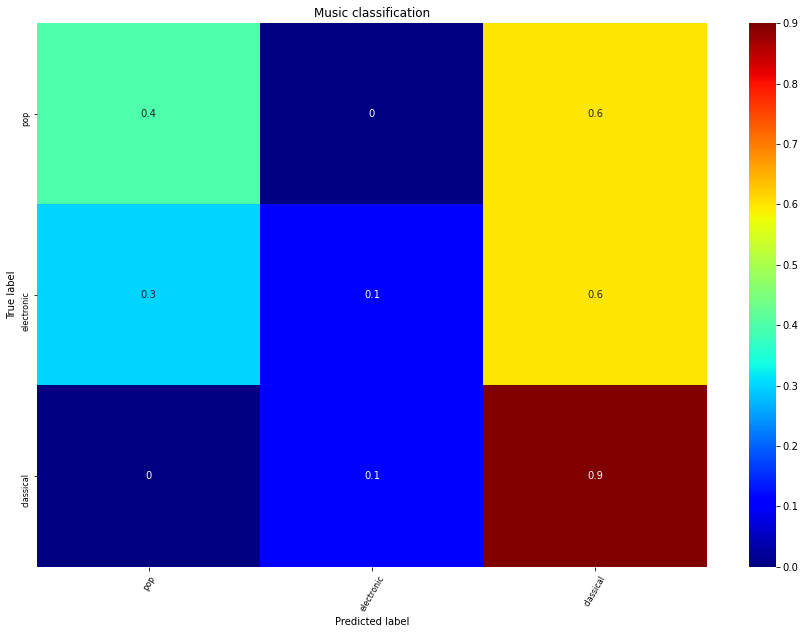

In [65]:
music_genre_dict = {0:'pop', 1:'electronic', 2:'classical'}
u = np.unique(test_spec_label)

# Plot confusion matrix
conf_mat = pd.DataFrame(conf_mat, columns= [music_genre_dict[x] for x in u], index= [music_genre_dict[x] for x in u])
plt.figure(figsize = (15,10))
sn.heatmap(conf_mat, annot=True, annot_kws={"size": 10}, cmap='jet')
plt.tick_params(labelsize=8)
plt.xticks(rotation= 60)
plt.title("Music classification")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
# plt.savefig(os.getcwd()+"/ConfusionMatrix_test.png")
plt.close()

(128, 8566)


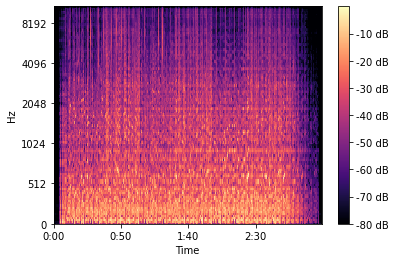

In [15]:
# Read audio

filename = './3100.wav'
y, sr = librosa.load(filename)

# Extract mel spectrogram

n_fft = 2048
n_mels = 128
hop_length = 512

S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

print(S.shape)